# Principal Component Analysis

In [1]:
import hail as hl
hl.init(spark_conf={'spark.driver.memory': '100g'}, tmp_dir='/home/olavur/tmp')

2021-11-04 13:10:56 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2021-11-04 13:10:57 WARN  Hail:37 - This Hail JAR was compiled for Spark 2.4.5, running with Spark 2.4.1.
  Compatibility is not guaranteed.
2021-11-04 13:10:57 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2021-11-04 13:10:57 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2021-11-04 13:10:57 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Running on Apache Spark version 2.4.1
SparkUI available at http://hms-beagle-6676655f87-9xllv:4043
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/fargen-1-exome/notebooks/main/hail-20211104-1310-0.2.61-3c86d3ba497a.log


In [2]:
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models.scales import LogScale
output_notebook()

Loading BokehJS ...

In [15]:
BASE_DIR = '/home/olavur/experiments/2020-11-13_fargen1_exome_analysis'
RESOURCES_DIR = '/data/other/resources'

## Load gnomAD data

**FIXME:** Load the `HIGH_QUALITY` file (gnomad.genomes.v3.1.hgdp_1kg_subset_dense_EXOME_HIGH_QUALITY.mt) when it's done.

In [16]:
gnomad_mt = hl.read_matrix_table(RESOURCES_DIR + '/gnomAD/hgdp_1kg_subset_dense/gnomad.genomes.v3.1.hgdp_1kg_subset_dense_EXOME_HIGH_QUALITY.mt')

In [5]:
n_variants, n_samples = gnomad_mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 7094228
Number of samples: 3942


## Load FarGen exome data

Load filtered, high-quality, variants.

In [6]:
fargen_mt = hl.read_matrix_table(BASE_DIR + '/data/mt/high_quality_variants.mt/')

In [7]:
n_variants, n_samples = fargen_mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 148305
Number of samples: 469


## Annotate population

The samples in the gnomAD data are annotated with population. Save these in a `pop` field.

In [8]:
gnomad_mt = gnomad_mt.annotate_cols(pop=gnomad_mt.population_inference.pop)

Count the number of samples in each population.

In [9]:
gnomad_mt.aggregate_cols(hl.agg.counter(gnomad_mt.pop))

{'nfe': 675,
 'fin': 92,
 'mid': 126,
 'oth': 47,
 'afr': 896,
 'eas': 801,
 'sas': 764,
 'amr': 541}

Make a `pop` parameter in the FarGen data as well.

In [10]:
fargen_mt = fargen_mt.annotate_cols(pop = 'fae')

## Merge datasets

Select only the `GT` and `pop` fields from both matrix tables, as these are the only ones we'll need.

In [11]:
fargen_mt = fargen_mt.select_entries('GT')
fargen_mt = fargen_mt.select_cols('pop')
fargen_mt = fargen_mt.select_rows()
gnomad_mt = gnomad_mt.select_entries('GT')
gnomad_mt = gnomad_mt.select_cols('pop')
gnomad_mt = gnomad_mt.select_rows()

**NOTE:** Variants that are unique to either dataset are lots in this union of sites. As such, the variance between populations can be under-estimated, as sites that are fixed in the Faroese population will not be included. However, these sites should contain enough information to summarize "coarse grained" population structure.

In [12]:
mt = fargen_mt.union_cols(gnomad_mt)

## Population filters

**NOTE:** The HWE filter should remove genotyping errors, but not HWE deviations due to population structure. The value of $p > 10^{-9}$ used here is quite low, so it is quite lenient.

Remove variants failing HWE test with $p > 10^{-9}$.

In [13]:
mt = mt.annotate_rows(hwe=hl.agg.hardy_weinberg_test(mt.GT))
mt = mt.filter_rows(mt.hwe.p_value > 1e-9)

Calculate allele frequencies.

In [14]:
# The number of alleles at the site is the sum of the ploidy at each site.
# This number should be twice the number of samples.
# If there are missing genotype calls, the number of alleles will be less.
AN_exprs = hl.agg.sum(mt.GT.ploidy)
mt = mt.annotate_rows(AN=AN_exprs)

# Calculate the number of alternate alleles at each site.
AC_exprs = hl.agg.sum(mt.GT.n_alt_alleles())
mt = mt.annotate_rows(AC=AC_exprs)

# Calculate the alternate allele frequency.
mt = mt.annotate_rows(AF=mt.AC / mt.AN)

**TODO:** I can increase the MAF threshold if still a lot of variants remain.

Remove variants with minor allele frequency under 0.05.

In [15]:
maf_filter = 0.05
mt = mt.filter_rows((mt.AF > maf_filter) & (mt.AF < (1 - maf_filter)))

## Filter indels

Remove all indels from the dataset.

In [16]:
mt = mt.filter_rows(hl.is_snp(mt.alleles[0], mt.alleles[1]))

### Write to file

In [18]:
if False:
    mt = mt.checkpoint(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe.mt', overwrite=True)
else:
    mt = hl.read_matrix_table(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe.mt')

[Stage 2:>                                                  (161 + 24) / 115152]2021-10-29 14:11:57 Hail: INFO: wrote matrix table with 64887 rows and 4411 columns in 115152 partitions to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/data/resources/gnomAD/fargen_gnomad_union_common_hwe_diallelic.mt
    Total size: 239.83 MiB
    * Rows/entries: 239.81 MiB
    * Columns: 23.01 KiB
    * Globals: 11.00 B
    * Smallest partition: 0 rows (20.00 B)
    * Largest partition:  58 rows (235.88 KiB)
[Stage 2:==================================>              (81975 + 24) / 115152]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
n_variants, n_samples = mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 64887
Number of samples: 4411


**FIXME:** write the dataset to file to speed up the remaining analysis.

## LD pruning

**TODO:** tune r2 parameter

In [20]:
pruned_variant_table = hl.ld_prune(mt.GT, r2=0.2, bp_window_size=500000)
mt = mt.filter_rows(hl.is_defined(pruned_variant_table[mt.row_key]))

2021-11-01 09:58:27 Hail: INFO: ld_prune: running local pruning stage with max queue size of 58204 variants
[Stage 3:===============================================>(115135 + 17) / 115152]2021-11-01 10:42:45 Hail: INFO: wrote table with 39680 rows in 115152 partitions to /home/olavur/tmp/Ixq5jaxRTPNXjXICarsdZ3
    Total size: 4.86 MiB
    * Rows: 4.86 MiB
    * Globals: 11.00 B
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  12 rows (502.00 B)
[Stage 5:====================================================>     (9 + 1) / 10]2021-11-01 11:13:40 Hail: INFO: Wrote all 20 blocks of 39680 x 4411 matrix with block size 4096.
[Stage 9:=====================================================>   (17 + 1) / 18]2021-11-01 11:38:27 Hail: INFO: wrote table with 24283 rows in 18 partitions to /home/olavur/tmp/CrgsIQfXs1C0Bu8db7GCML
    Total size: 970.73 KiB
    * Rows: 374.72 KiB
    * Globals: 596.01 KiB
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  2999 rows

In [21]:
if False:
    mt = mt.checkpoint(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep.mt', overwrite=True)
else:
    mt = hl.read_matrix_table(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep.mt')

[Stage 13:==============================================>(115141 + 11) / 115152]2021-11-01 13:10:17 Hail: INFO: wrote matrix table with 27590 rows and 4411 columns in 115152 partitions to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep.mt
    Total size: 99.99 MiB
    * Rows/entries: 99.97 MiB
    * Columns: 23.01 KiB
    * Globals: 11.00 B
    * Smallest partition: 0 rows (20.00 B)
    * Largest partition:  10 rows (42.92 KiB)


In [22]:
n_variants, n_samples = mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 27590
Number of samples: 4411


## Filter related individuals

Estimate the relatedness between the samples by the PC-Relate method, with a minimum alternate allele frequency of 0.001.

In [ ]:
pc_rel = hl.pc_relate(mt.GT, 0.001, k=2, statistics='kin')

[Stage 14:==============================================>(115115 + 24) / 115152]2021-11-01 14:04:04 Hail: INFO: hwe_normalized_pca: running PCA using 27590 variants.
[Stage 15:============>                                   (29480 + 24) / 115152]

In [ ]:
pairs = pc_rel.filter(pc_rel['kin'] > 2**(-4))

Then we find the maximal independent set, consistent of the samples to remove.

In [ ]:
related_samples_to_remove = hl.maximal_independent_set(pairs.i, pairs.j, keep=False)

Now we filter these individuals from the matrix table.

In [ ]:
mt = mt.filter_cols(hl.is_defined(related_samples_to_remove[mt.col_key]), keep=False)

Make a checkpoint, caching all operations done on the matrix table.

In [34]:
if False:
    mt = mt.checkpoint(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_rel_pruned.mt', overwrite=True)
else:
    mt = hl.read_matrix_table(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_rel_pruned.mt')

In [35]:
n_variants, n_samples = mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 27590
Number of samples: 3441


## PCA

In [36]:
eigenvalues, scores, loadings = hl.hwe_normalized_pca(mt.GT, k=mt.count_cols())

[Stage 68:==============================================>(115023 + 24) / 115152]2021-11-02 10:24:40 Hail: INFO: hwe_normalized_pca: running PCA using 27590 variants.
[Stage 69:==============================================>(115065 + 24) / 115152]2021-11-02 10:35:03 Hail: INFO: pca: running PCA with 3441 components...
[Stage 72:==============================================>(115089 + 25) / 115152]

In [37]:
mt = mt.annotate_cols(scores = scores[mt.s].scores)

Calculate the proportion of variance explained by each component, and annotate the matrix table with this data.

In [44]:
import numpy as np

prop_var = np.array(eigenvalues) / sum(eigenvalues)

mt = mt.annotate_globals(pca_prop_var = list(prop_var))

In [4]:
if False:
    mt = mt.checkpoint(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_pca.mt', overwrite=True)
else:
    mt = hl.read_matrix_table(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_pca.mt')

In [5]:
prop_var = mt.pca_prop_var.collect()[0]

In [64]:
pc_idx1 = 0
pc_idx2 = 1
p = hl.plot.scatter(mt.scores[pc_idx1],
                    mt.scores[pc_idx2],
                    label=hl.str(mt.pop),
                    title='PCA', xlabel='PC{n} ({p:.2f}%)'.format(n=pc_idx1+1, p=prop_var[pc_idx1] * 100), ylabel='PC{n} ({p:.2f}%)'.format(n=pc_idx2+1, p=prop_var[pc_idx2] * 100))
p.plot_width = 800
p.plot_height = 600
show(p)

In [65]:
pc_idx1 = 0
pc_idx2 = 2
p = hl.plot.scatter(mt.scores[pc_idx1],
                    mt.scores[pc_idx2],
                    label=hl.str(mt.pop),
                    title='PCA', xlabel='PC{n} ({p:.2f}%)'.format(n=pc_idx1+1, p=prop_var[pc_idx1] * 100), ylabel='PC{n} ({p:.2f}%)'.format(n=pc_idx2+1, p=prop_var[pc_idx2] * 100))
p.plot_width = 800
p.plot_height = 600
show(p)

In [66]:
pc_idx1 = 1
pc_idx2 = 2
p = hl.plot.scatter(mt.scores[pc_idx1],
                    mt.scores[pc_idx2],
                    label=hl.str(mt.pop),
                    title='PCA', xlabel='PC{n} ({p:.2f}%)'.format(n=pc_idx1+1, p=prop_var[pc_idx1] * 100), ylabel='PC{n} ({p:.2f}%)'.format(n=pc_idx2+1, p=prop_var[pc_idx2] * 100))
p.plot_width = 800
p.plot_height = 600
show(p)

## Plot with seaborn

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

In [8]:
cols_ht = mt.cols()
cols_ht = cols_ht.annotate(pc1 = cols_ht.scores[0], pc2 = cols_ht.scores[1], pc3 = cols_ht.scores[2])
temp_pd = cols_ht.select('pop', 'pc1', 'pc2', 'pc3').to_pandas()

[Stage 0:>                                                        (0 + 16) / 16]2021-11-04 13:12:09 Hail: INFO: Coerced sorted dataset
[Stage 1:>                                                        (0 + 16) / 16]

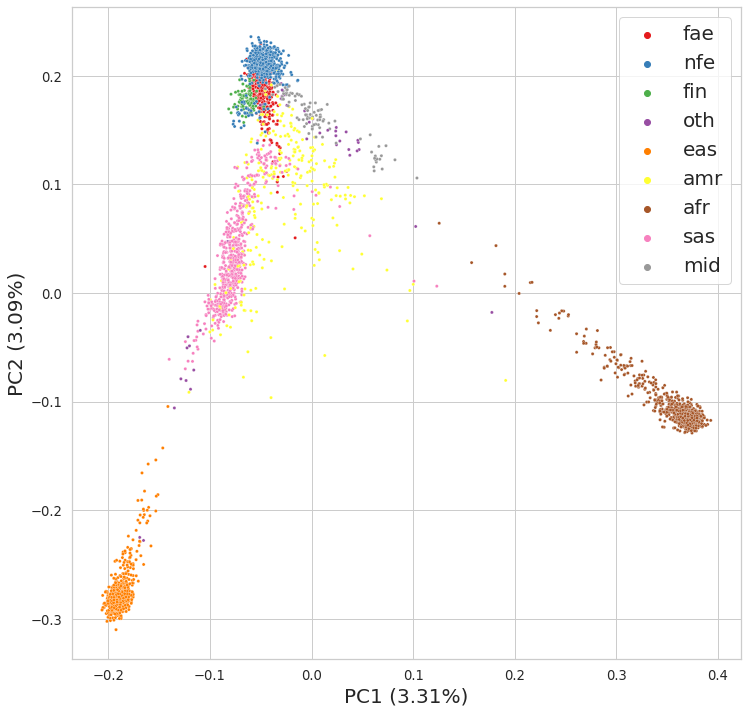

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.scatterplot(
    data=temp_pd, x='pc1', y='pc2', hue='pop',
    ax=ax, s=10, palette='Set1'
)

_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('PC{n} ({p:.2f}%)'.format(n=1, p=prop_var[0] * 100), fontsize=20)
_ = ax.set_ylabel('PC{n} ({p:.2f}%)'.format(n=2, p=prop_var[1] * 100), fontsize=20)

In [14]:
fig = g.get_figure()
fig.savefig(BASE_DIR + '/data/figures/pca_merged.png', format='png', dpi=400)

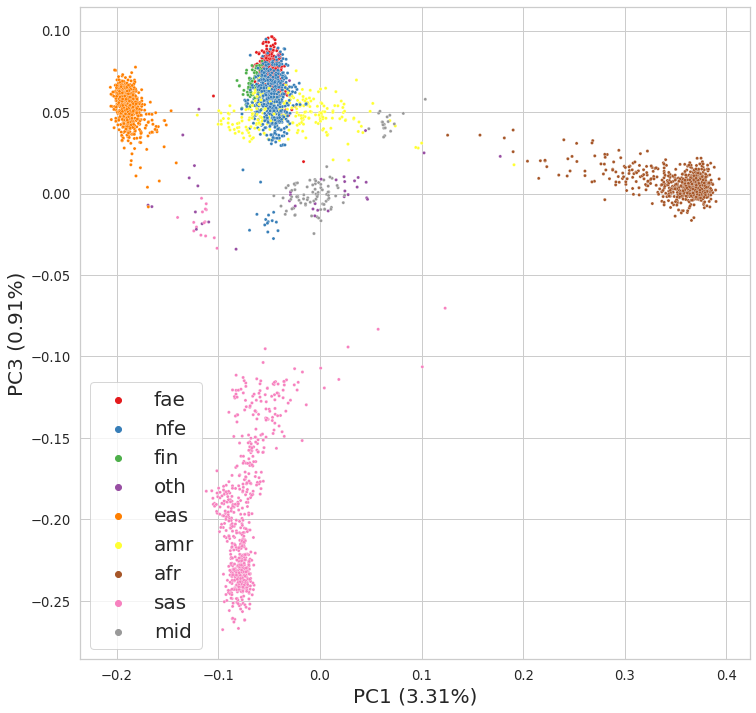

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.scatterplot(
    data=temp_pd, x='pc1', y='pc3', hue='pop',
    ax=ax, s=10, palette='Set1'
)

_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('PC{n} ({p:.2f}%)'.format(n=1, p=prop_var[0] * 100), fontsize=20)
_ = ax.set_ylabel('PC{n} ({p:.2f}%)'.format(n=3, p=prop_var[2] * 100), fontsize=20)

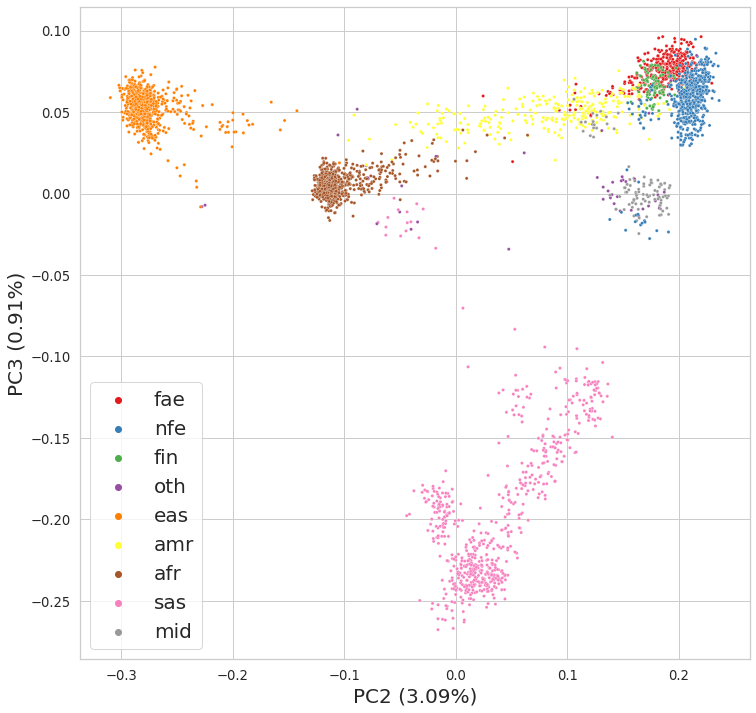

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.scatterplot(
    data=temp_pd, x='pc2', y='pc3', hue='pop',
    ax=ax, s=10, palette='Set1'
)

_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('PC{n} ({p:.2f}%)'.format(n=2, p=prop_var[1] * 100), fontsize=20)
_ = ax.set_ylabel('PC{n} ({p:.2f}%)'.format(n=3, p=prop_var[2] * 100), fontsize=20)

### Proportion of variance explained by PCA

In [61]:
import seaborn as sns
from matplotlib import pyplot as plt

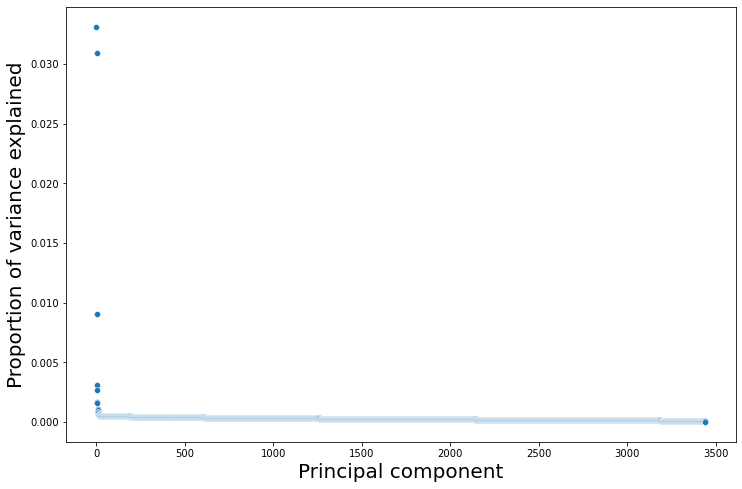

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.set_theme(style='whitegrid', font_scale=1.2)


g = sns.scatterplot(data=prop_var)

_ = ax.set_ylabel('Proportion of variance explained', fontsize=20)
_ = ax.set_xlabel('Principal component', fontsize=20)

## European-only PCA

In [21]:
mt = hl.read_matrix_table(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_rel_pruned.mt')

In [22]:
pops_exprs = hl.array(['fae', 'fin', 'nfe'])
mt = mt.filter_cols(pops_exprs.contains(mt.pop))

In [23]:
mt.aggregate_cols(hl.agg.counter(mt.pop))

{'fae': 361, 'fin': 92, 'nfe': 568}

In [24]:
eigenvalues, scores, loadings = hl.hwe_normalized_pca(mt.GT, k=mt.count_cols())

[Stage 3:================================================>(115143 + 9) / 115152]2021-11-05 11:28:27 Hail: INFO: hwe_normalized_pca: running PCA using 27590 variants.
[Stage 4:===============================================>(115110 + 24) / 115152]2021-11-05 11:38:31 Hail: INFO: pca: running PCA with 1021 components...
[Stage 7:===============================================>(115128 + 24) / 115152]

In [25]:
mt = mt.annotate_cols(scores = scores[mt.s].scores)

Calculate the proportion of variance explained by each component, and annotate the matrix table with this data.

In [26]:
import numpy as np

prop_var = np.array(eigenvalues) / sum(eigenvalues)

mt = mt.annotate_globals(pca_prop_var = list(prop_var))

In [27]:
if False:
    mt = mt.checkpoint(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_eur_only_pca.mt', overwrite=True)
else:
    mt = hl.read_matrix_table(BASE_DIR + '/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_eur_only_pca.mt')

[Stage 8:===============================================>(115128 + 24) / 115152]2021-11-05 12:52:23 Hail: INFO: wrote matrix table with 27590 rows and 1021 columns in 115152 partitions to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/data/resources/gnomAD/fargen_gnomad_union_common_hwe_indep_eur_only_pca.mt
    Total size: 34.61 MiB
    * Rows/entries: 26.60 MiB
    * Columns: 8.00 MiB
    * Globals: 8.02 KiB
    * Smallest partition: 0 rows (20.00 B)
    * Largest partition:  10 rows (10.45 KiB)


In [35]:
n_variants, n_samples = mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 27590
Number of samples: 1021


In [28]:
prop_var = mt.pca_prop_var.collect()[0]

In [29]:
cols_ht = mt.cols()
cols_ht = cols_ht.annotate(pc1 = cols_ht.scores[0], pc2 = cols_ht.scores[1], pc3 = cols_ht.scores[2])
temp_pd = cols_ht.select('pop', 'pc1', 'pc2', 'pc3').to_pandas()

2021-11-05 12:55:36 Hail: INFO: Coerced sorted dataset


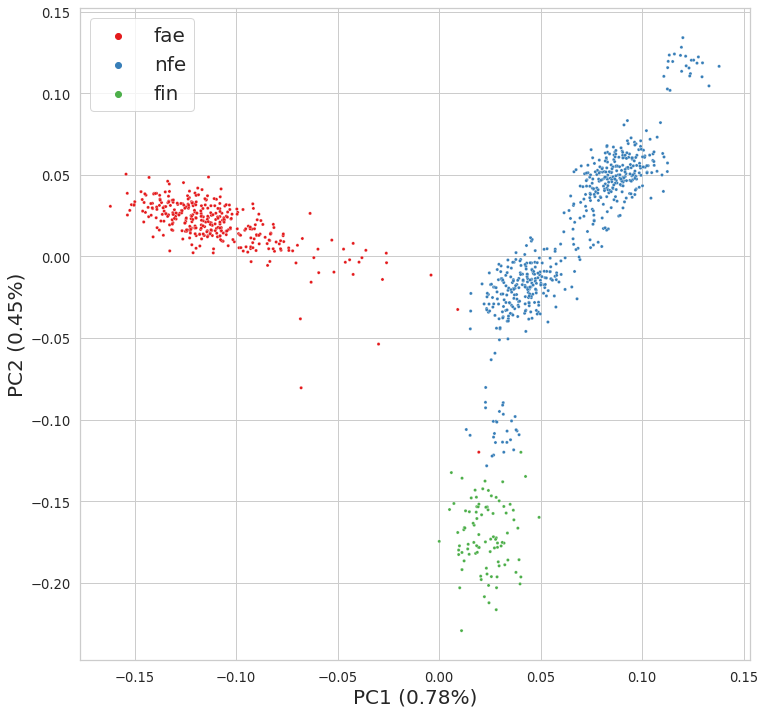

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.scatterplot(
    data=temp_pd, x='pc1', y='pc2', hue='pop',
    ax=ax, s=10, palette='Set1'
)

_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('PC{n} ({p:.2f}%)'.format(n=1, p=prop_var[0] * 100), fontsize=20)
_ = ax.set_ylabel('PC{n} ({p:.2f}%)'.format(n=2, p=prop_var[1] * 100), fontsize=20)

In [34]:
fig = g.get_figure()
fig.savefig(BASE_DIR + '/data/figures/pca_merged.png', format='png', dpi=400)

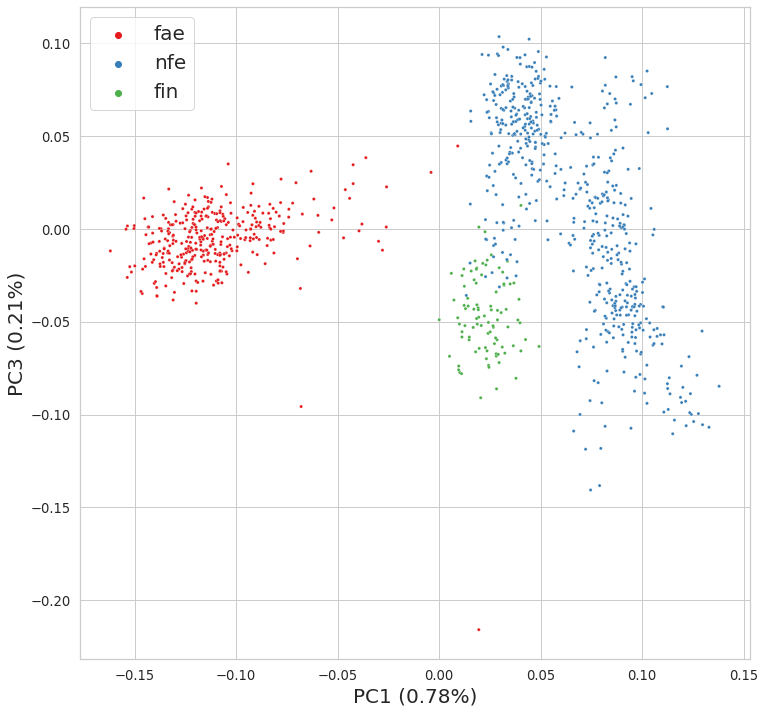

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.scatterplot(
    data=temp_pd, x='pc1', y='pc3', hue='pop',
    ax=ax, s=10, palette='Set1'
)

_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('PC{n} ({p:.2f}%)'.format(n=1, p=prop_var[0] * 100), fontsize=20)
_ = ax.set_ylabel('PC{n} ({p:.2f}%)'.format(n=3, p=prop_var[2] * 100), fontsize=20)

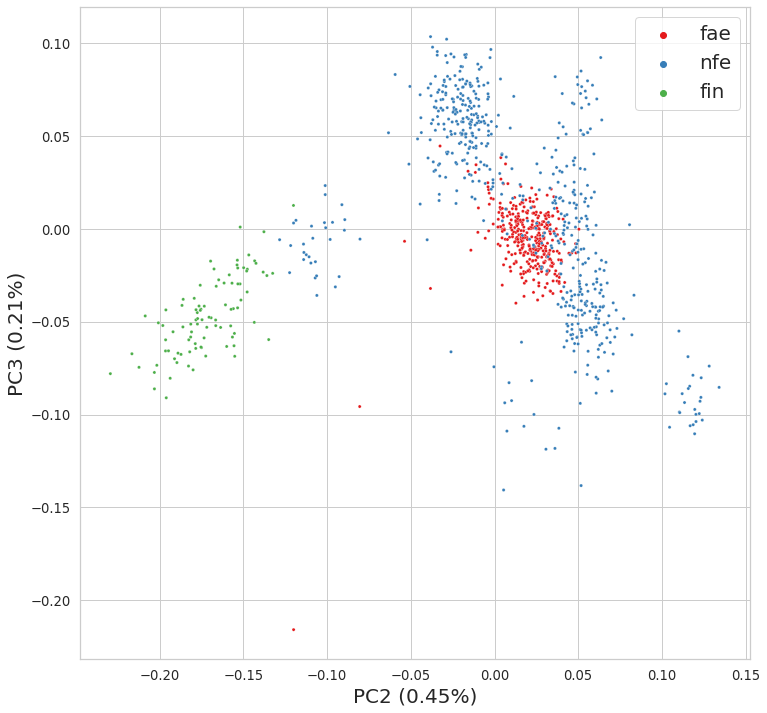

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.scatterplot(
    data=temp_pd, x='pc2', y='pc3', hue='pop',
    ax=ax, s=10, palette='Set1'
)

_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('PC{n} ({p:.2f}%)'.format(n=2, p=prop_var[1] * 100), fontsize=20)
_ = ax.set_ylabel('PC{n} ({p:.2f}%)'.format(n=3, p=prop_var[2] * 100), fontsize=20)